#### In this notebook, I will train a conditional flow to add RA and Dec, and I will use the LSST Error Model to add errors.

In [47]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.distributions import Uniform

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

#### Load the DC2 Data

In [3]:
data = pd.read_pickle("dc2.pkl")
# select a subset
data = data.iloc[:100000]
# print some of the data
data

,ra,dec,redshift,u,g,r,i,z,y
0,54.711133,-37.129134,2.008235,27.136230,26.670242,26.667273,26.582212,26.357750,26.152222
1,57.596370,-44.416915,0.978697,27.316854,27.212221,26.671032,25.900785,25.353924,25.256409
2,67.631866,-35.667108,1.141199,27.646139,27.523197,27.239439,26.955040,26.153460,26.039215
3,61.183022,-29.018957,0.380182,30.007523,28.263083,26.901390,26.366058,26.075935,25.875998
4,71.067002,-29.777124,1.215204,25.069988,25.117722,25.167130,25.186823,24.732811,24.613487
...,...,...,...,...,...,...,...,...,...
99995,57.375946,-27.211371,0.623730,30.050865,28.272827,26.828554,25.890543,25.548849,25.303030
99996,52.605179,-35.967782,1.040866,26.271753,26.185188,25.913502,25.455269,24.915035,24.887421
99997,57.826532,-38.100684,2.333732,28.247265,27.105297,26.804291,26.827522,26.631718,26.423748
99998,65.119623,-30.090240,1.441057,25.615845,25.908867,25.973932,25.956875,25.945831,25.618866


#### Create a conditional flow to model RA and Dec as a function of redshift and colors

Note that because the RA and Dec in this set are fairly concentrated on the sky, I won't use circular splines, but since the RA and Dec have sharp cutoffs, I will use uniform distributions.

In [79]:
# pick means and stds so that each has domain (-3, 3)
means = data[["ra", "dec"]].mean().values
stds = np.abs((data[["ra", "dec"]].max().values - means)/3)

# construct our bijector
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, n_conditions=7),
)

latent = Uniform((-3, 3), (-3, 3))

cflow = Flow(data.columns[:2], bijector, latent=latent,
                 conditional_columns=data.columns[2:])

We should standard scale the conditional columns before interaction with the flow. Let's create a function to do this for us

In [80]:
conditional_columns = data.columns[2:]
M = data[conditional_columns].mean()
S = data[conditional_columns].std()
def condition_scaler(data):
    scaled_data = data.copy()
    scaled_data[conditional_columns] = (data[conditional_columns] - M) / S
    return scaled_data

#### Train the flow

In [81]:
%%time
losses = cflow.train(condition_scaler(data), epochs=2000, verbose=True)

Training 2000 epochs 
Loss:
6.2644
5.9911
5.8901
5.8492
5.8162
5.7819
5.7599
5.7381
5.7291
5.7010
5.7021
5.6757
5.6982
5.6896
5.6808
5.6515
5.6425
5.6205
5.6247
5.5923
5.6095
CPU times: user 23min 18s, sys: 3min 38s, total: 26min 56s
Wall time: 15min 28s


#### Plot the results

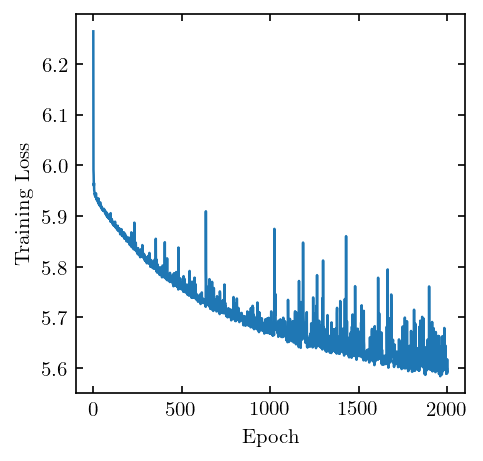

In [82]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

In [83]:
samples = cflow.sample(1, conditions=condition_scaler(data[:10000]), seed=0)
samples[conditional_columns] = data[conditional_columns]

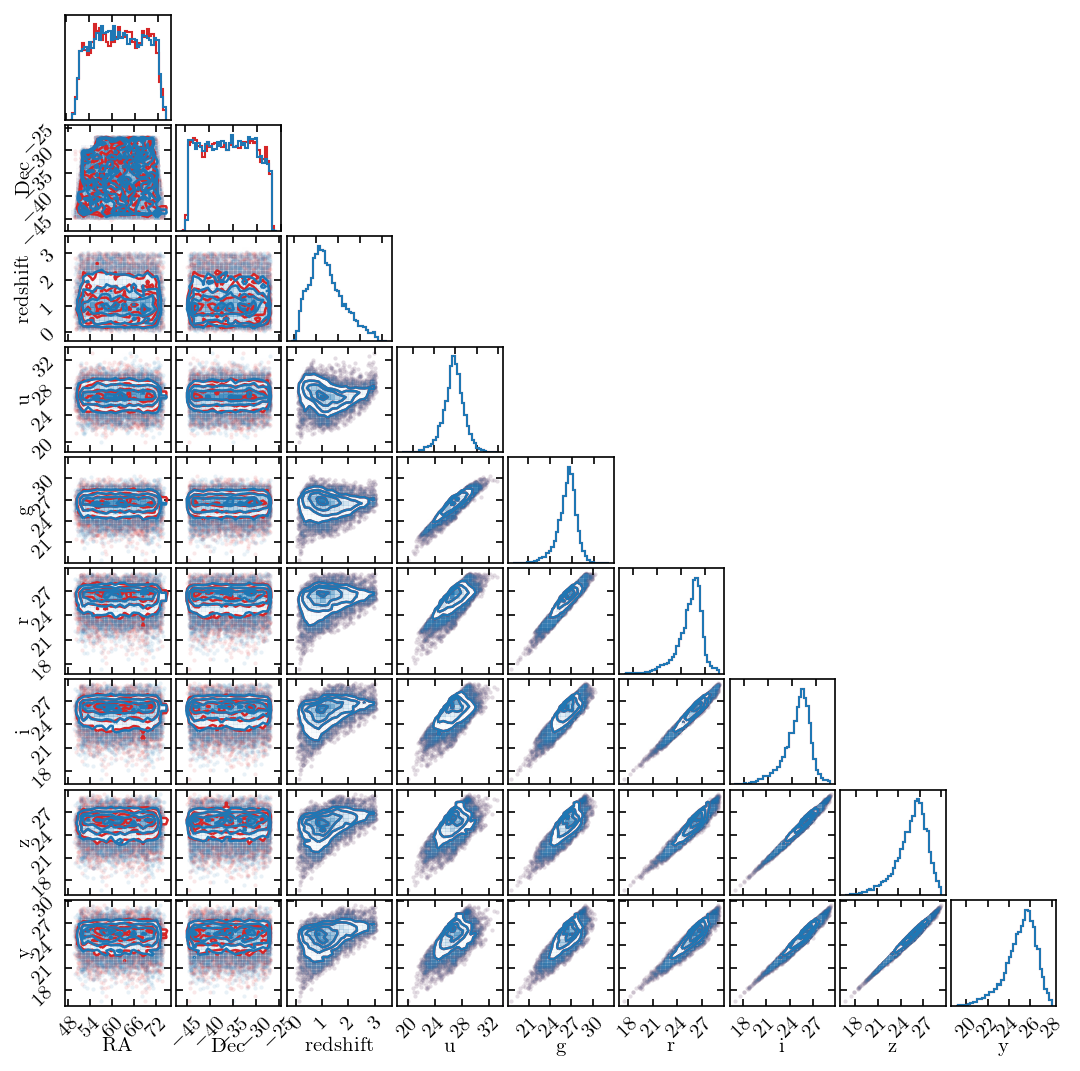

In [85]:
fig = plt.figure(figsize=(twocol, twocol))

ranges = [(49,74), (-46,-26), (-0.1,3.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0',
              labels=["RA", "Dec", "redshift", "u", "g", "r", "i", "z", "y"]);